# Import Data from Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chomd 600 ~/.kaggle/kaggle.json

/bin/bash: chomd: command not found


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:37<00:00, 56.4MB/s]
100% 5.20G/5.20G [00:37<00:00, 148MB/s] 


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: Data/ham10000_images_part_2/ISIC_002

In [ ]:
!pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56442 sha256=d95fa8056f6b7c835c5e5c932c5cdcf43c930197dd327dc88d9baed30872869b
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Reading & Processing data

In [ ]:
base_skin_dir = os.path.join('/content/', 'Data')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0027...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0026...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/Data/ham10000_images_part_2/ISIC_0031...,Benign keratosis-like lesions,2


# Data Cleaning

In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [ ]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [ ]:
print(skin_df.dtypes)


lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# EDA

<Axes: >

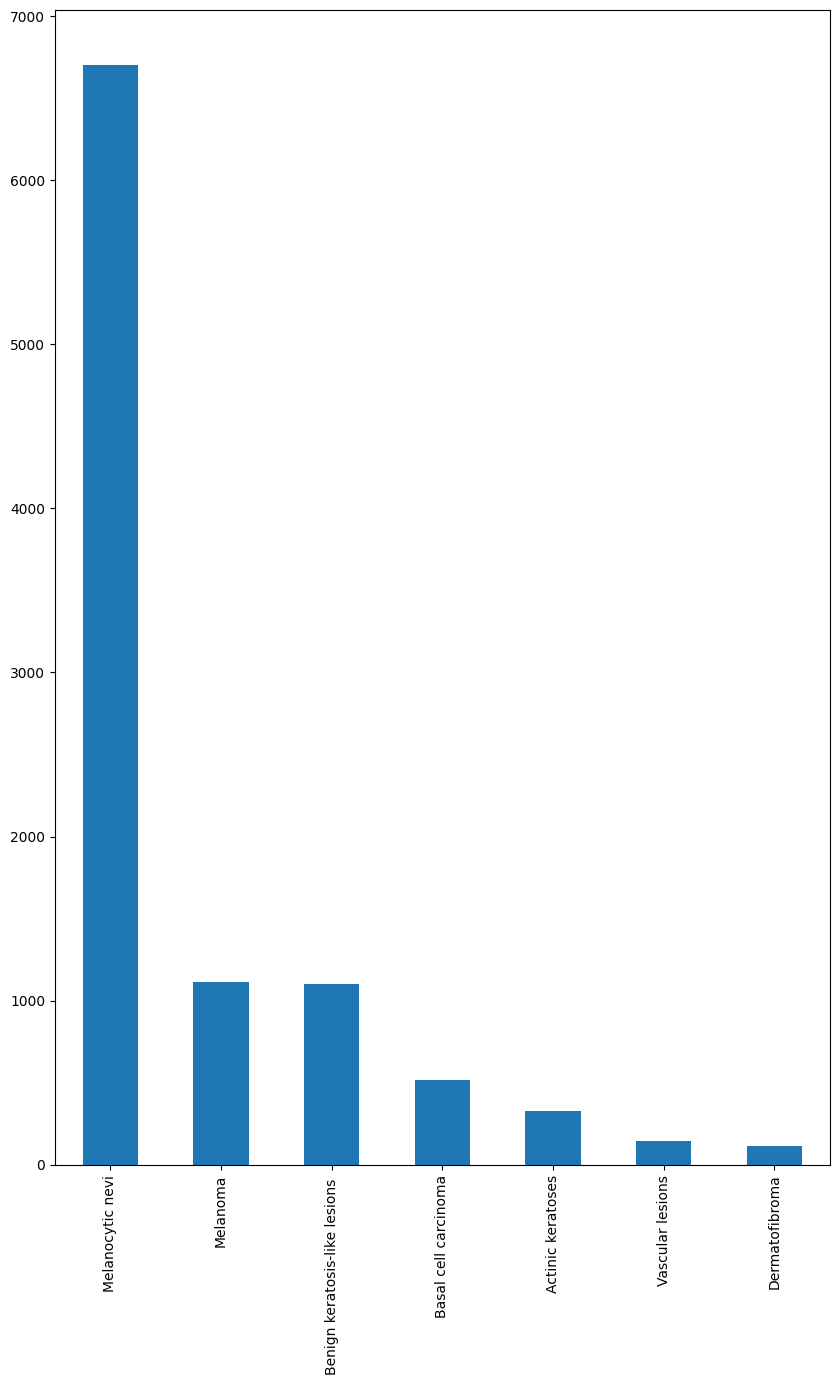

In [ ]:
fid, ax1 = plt.subplots(1, 1, figsize=(10, 15))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


Plotting of Technical Validation field (ground truth) which is dx_type to see the distribution of its 4 categories which are listed below :
1. **Histopathology(Histo)**: Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.
2. **Confocal:** Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.
3. **Follow-up:** If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
4. **Consensus:** For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

<Axes: >

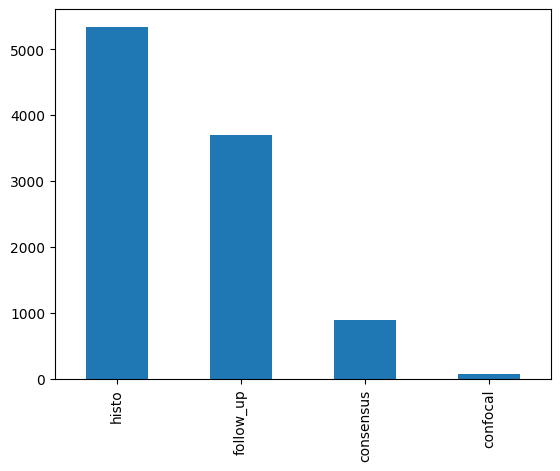

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<Axes: >

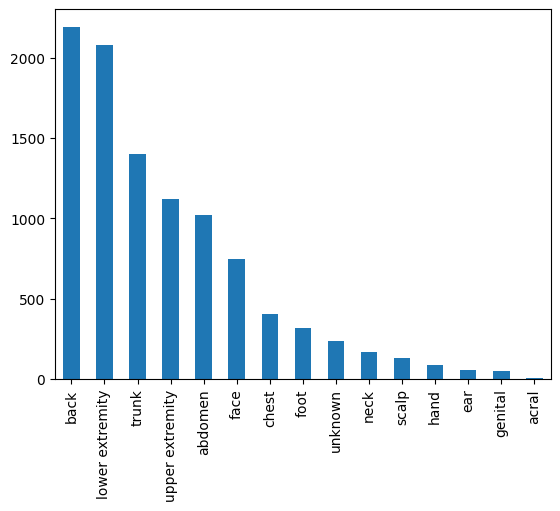

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')


<Axes: >

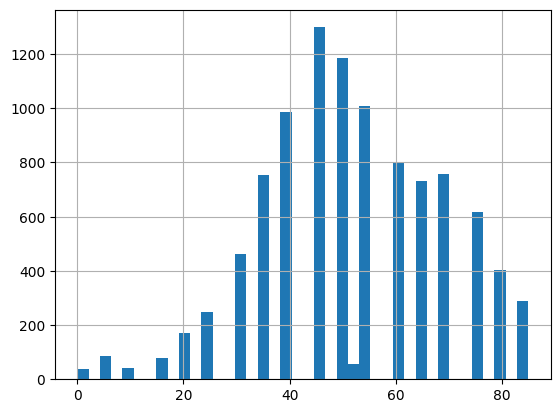

In [ ]:
skin_df['age'].hist(bins=40)


<Axes: >

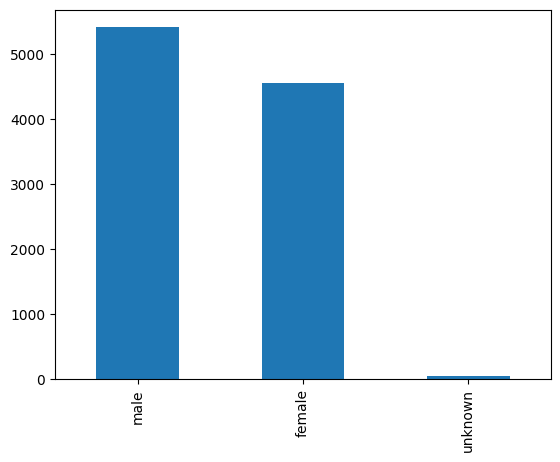

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')


In [ ]:
skin_df['sex'].value_counts()


male       5406
female     4552
unknown      57
Name: sex, dtype: int64

# Loading and resizing of images

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x:np.asarray(Image.open(x).resize((128,128))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0027...,Benign keratosis-like lesions,2,"[[[189, 152, 194], [192, 156, 199], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2,"[[[24, 13, 22], [24, 14, 22], [25, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0026...,Benign keratosis-like lesions,2,"[[[187, 127, 135], [190, 134, 146], [193, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/Data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [24, 11, 19], [29, 15, 25], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/Data/ham10000_images_part_2/ISIC_0031...,Benign keratosis-like lesions,2,"[[[129, 87, 109], [141, 96, 119], [151, 106, 1..."


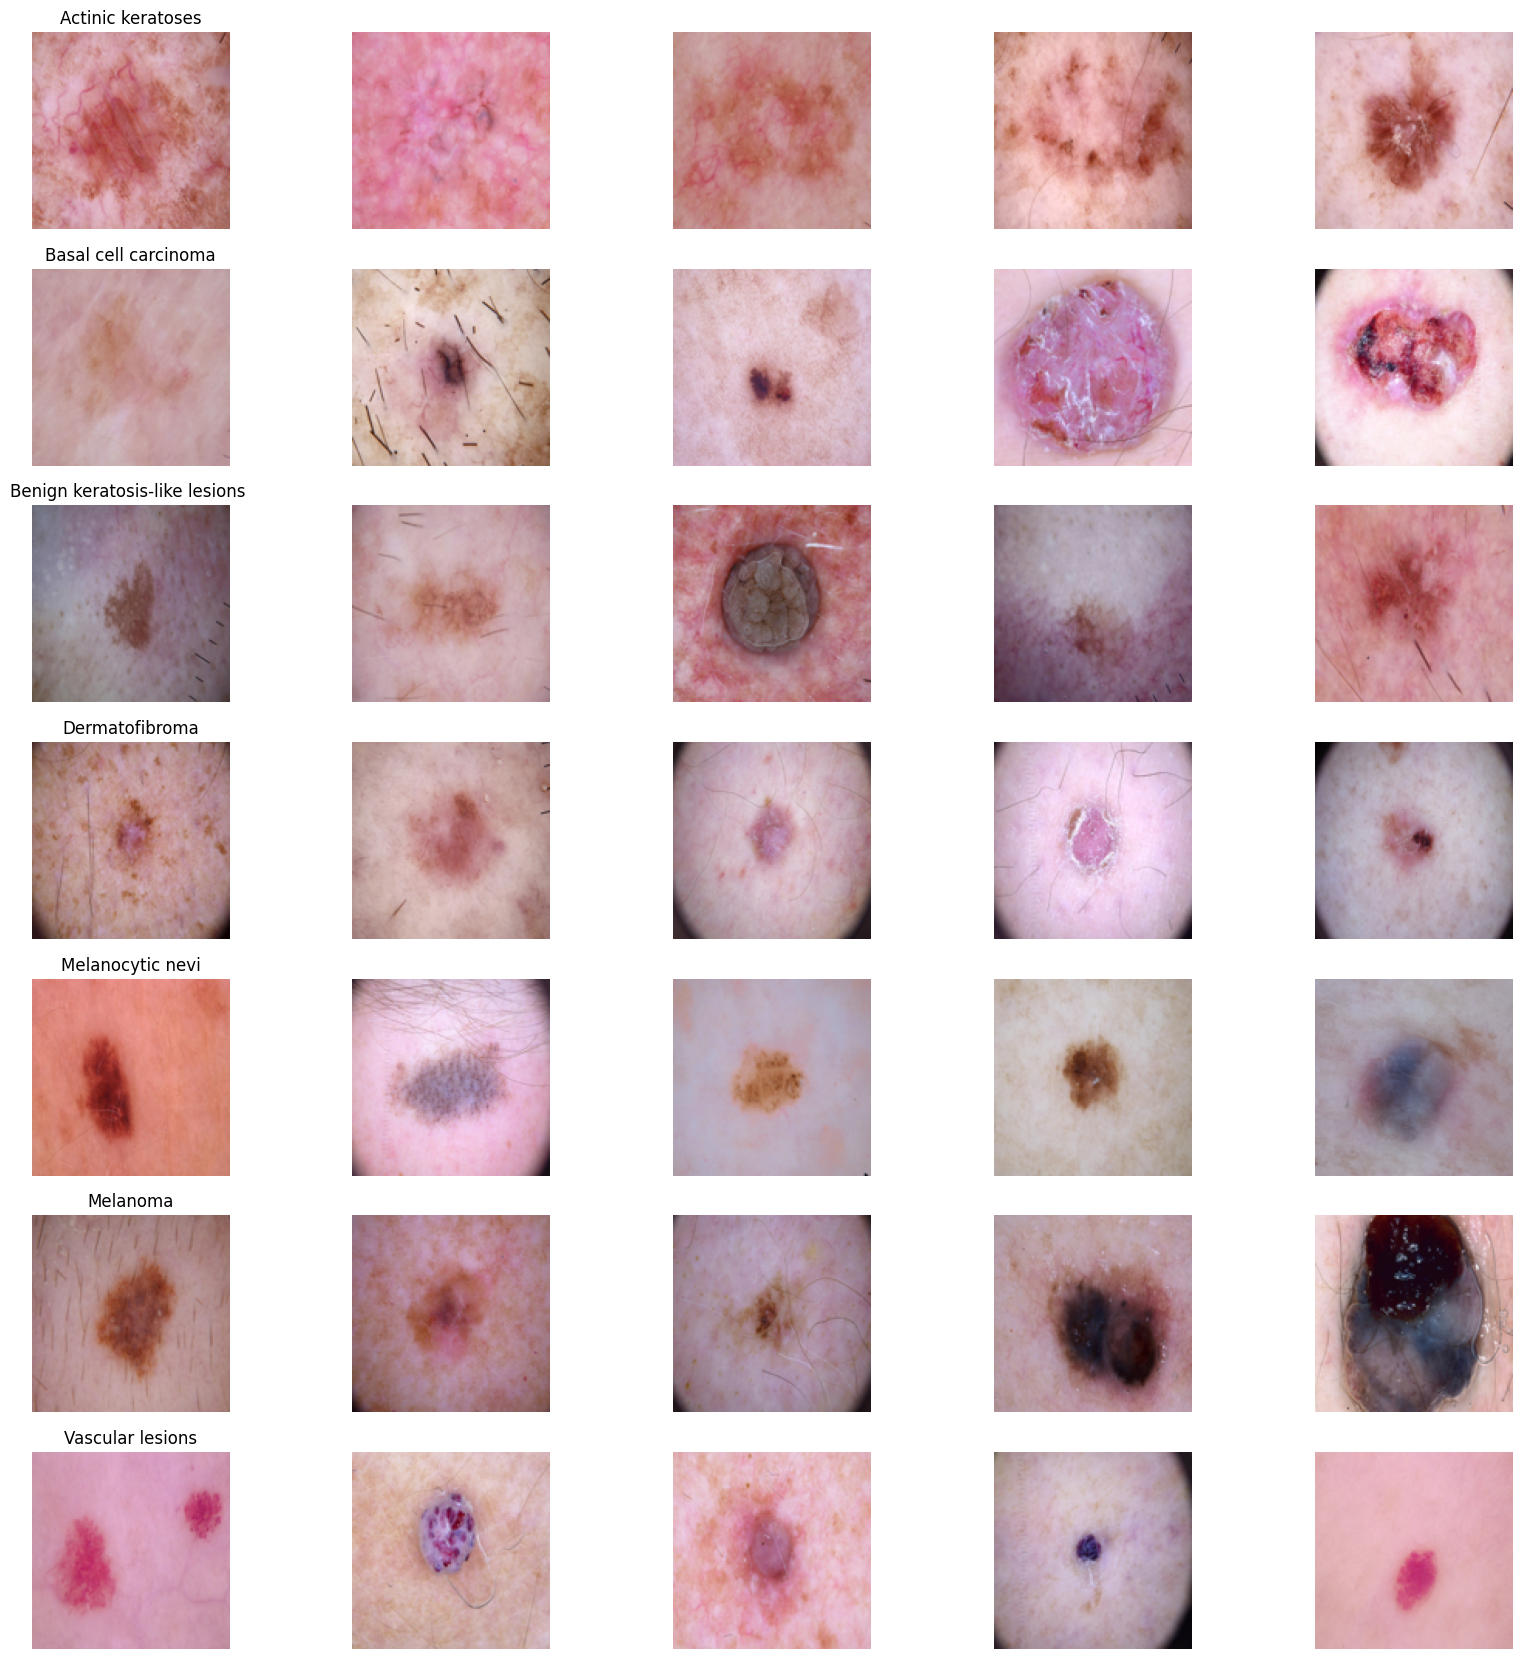

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
# Checking the image size distribution
skin_df['image'].map(lambda x:x.shape).value_counts()

(128, 128, 3)    10015
Name: image, dtype: int64

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']
target

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    5
Name: cell_type_idx, Length: 10015, dtype: int8

# Train Test Split

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# Normalization

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(128, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(128, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(128, 128, 3))

# Model Building
###CNN

In [ ]:
# input_shape = (128, 128, 3)
# num_classes = 7

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
# model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.40))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
def accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

model=Sequential()

model.add(Conv2D(64,(2,2),input_shape=(128,128,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Dropout(0.3))

model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())
#
model.add(Dropout(0.3))
model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())

#
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))

# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 512)       131584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 512)      0         
 2D)                                                             
                                                        

# ResNet50V2

In [ ]:
import tensorflow as tf


In [ ]:
res=tf.keras.applications.ResNet50V2(input_shape=(128,128,3),weights='imagenet', include_top=False)
for i in res.layers:
    i.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    res,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation = 'softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 7)                 229383    
                                                                 
Total params: 23,794,183
Trainable params: 229,383
Non-trainable params: 23,564,800
_________________________________________________________________
None


# Setting Optimizer and Annealer
Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm. We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy". The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. I choosed Adam optimizer because it combines the advantages of two other extensions of stochastic gradient descent. Specifically:

1. Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

2. Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp.

Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [ ]:
# Define the optimizer
import tensorflow as tf

# Will use Adam Because it is speed and good
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# Will use loss "binary_crossentropy" because our brediction is binary classification 
model.compile(loss="categorical_crossentropy", optimizer= optimizer, metrics=["accuracy"])


In [ ]:
# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.0002, patience=2,
                                      monitor="val_accuracy", min_lr=0.000001)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor = "val_loss",
                                                  restore_best_weights=True)


# Data Augmentation
It is the optional step. In order to avoid overfitting problem, we need to expand artificially our HAM 10000 dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

For the data augmentation, i choosed to : Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height Once our model is ready, we fit the training dataset .

# Fitting the model
In this step finally I fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 50 epochs as small as your batch size will be more efficiently your model will train and I have choosen 50 epochs to give the model sufficient epochs to train

In [ ]:
# Fit the model
epochs = 30
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[lr_scheduler,early_stopping_cb])

<ipython-input-32-27579148c265>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/30
721/721 [==============================] - 82s 92ms/step - loss: 13.1769 - accuracy: 0.5904 - val_loss: 1.7536 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 2/30
721/721 [==============================] - 66s 91ms/step - loss: 2.4498 - accuracy: 0.6524 - val_loss: 1.2184 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 3/30
721/721 [==============================] - 65s 90ms/step - loss: 1.4609 - accuracy: 0.6644 - val_loss: 1.0986 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 4/30
721/721 [==============================] - 64s 88ms/step - loss: 1.2866 - accuracy: 0.6655 - val_loss: 1.2733 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 5/30
721/721 [==============================] - 66s 91ms/step - loss: 1.1393 - accuracy: 0.6703 - val_loss: 1.0251 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 6/30
721/721 [==============================] - 66s 91ms/step - loss: 1.1006 - accuracy: 0.6709 - val_loss: 1.0282 - val_accuracy: 0.6808 - lr: 1.0000e-06
Epoch 7/30
721/721 [==============================] -

# Model Evaluation
In this step we will check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

26/26 [==============================] - 1s 54ms/step - loss: 1.0211 - accuracy: 0.6808
Validation: accuracy = 0.680798  ;  loss_v = 1.021060
Test: accuracy = 0.659011  ;  loss = 1.102227


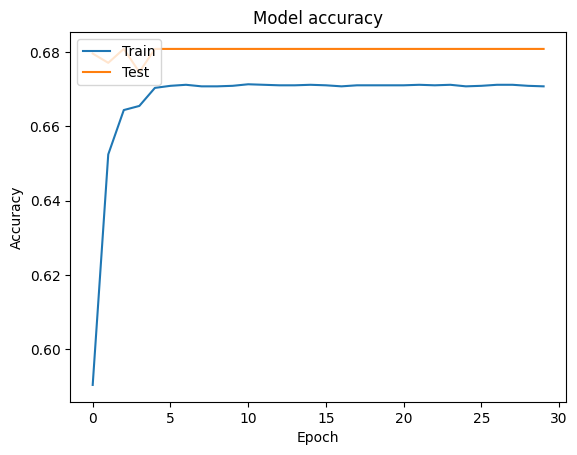

In [ ]:
# plot_model_history(history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


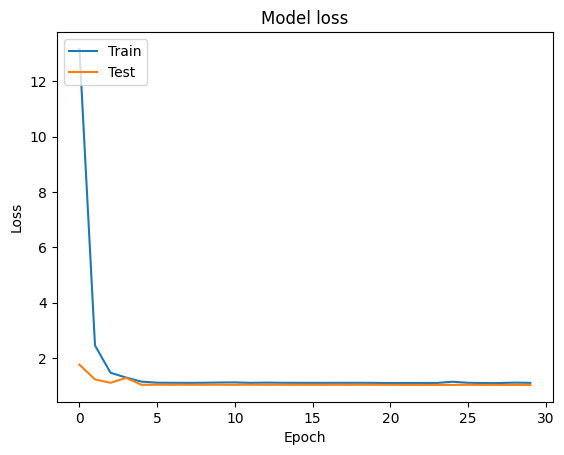

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Transfer Learning

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x:np.asarray(Image.open(x).resize((331,331))))

In [ ]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(331, 331, 3)    10015
Name: image, dtype: int64

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Feature extraction
# NASNetLarge img(331,331)
feature_model = keras.applications.NASNetLarge(weights="imagenet", include_top=False)

features = feature_model.predict(x_train)
print(features.shape)
print(features[0].flatten().shape)

343610240/343610240 [==============================] - 11s 0us/step


ValueError: ignored

# Inference

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [ ]:
# https://www.gradio.app/ml_examples

import tensorflow as tf
from tensorflow import keras
import numpy as np
import gradio as gr
import requests
#from PIL import Image
import cv2


def inference(img):
    labels =['Actinic keratoses','Basal cell carcinoma','Benign keratosis-like lesions','Dermatofibroma','Melanocytic nevi','Melanoma','Vascular lesions']
    H,W,C = 128,128,3
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H, W)) 
    img = np.array(img)
    men = np.mean(img)
    stdd = np.std(img)
    img = (img-men)/stdd
    img = img.reshape(1,H,W,C)
    pred = model.predict(img).flatten()
    # prediction = [pred[0], 1-pred[0]]
    dictionary = dict(zip(labels, map(float, pred)))
    return dictionary


nbr_top_classes = 7
gr.Interface(fn=inference, 
             inputs=gr.inputs.Image(), 
             outputs=gr.outputs.Label(num_top_classes=nbr_top_classes),
             theme="darkdefault"
             ).launch(share=True) #, debug=True Use in Colab


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:663: UserWarning: Cannot load darkdefault. Caught Exception: The space darkdefault does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {s

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5683f9834e27354962.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
